In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import pad_sequences
from gensim.models import Word2Vec

2025-06-11 10:47:16.494018: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 10:47:16.507755: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 10:47:16.605358: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-11 10:47:16.733378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-11 10:47:16.840836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registe

In [2]:
path= "../raw_data/train_df_ml_clean.csv"

In [3]:
clean_df = pd.read_csv(path)

In [4]:
clean_df = clean_df.sample(frac=0.1)
len(clean_df)

360000

In [5]:
clean_df.head()

,label,text,clean_text
1330262,1,"REALLY FUNNY: This was a great series finale, ...",really funny this wa a great series finale and...
507063,1,another great sparks tear-jerker: this book is...,another great spark tearjerker this book is we...
902322,0,Hard to get into: I started this book twice no...,hard to get into i started this book twice now...
3221197,0,Disappointed: Product was returned. Item made ...,disappointed product wa returned item made in ...
1782248,0,Nifty little tool but the door will break: Its...,nifty little tool but the door will break it a...


In [6]:
X = clean_df['clean_text'].to_numpy()
y = clean_df['label'].to_numpy()

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
X_val[:10]

array(['these are great a whole food vitamin and they taste yummy according to the kiddos they are easy to remember a they are only per day too',
       'plaindisappointing this is a typical best seller that i fell into where the character are simple predictable in their illogical behavior sappy and boring the plot is of little relevence to any real life situation and the book wa neither educative nor entertaining i have a hard time knowing why there ha been such a favorable response to this work other than it doesnt tax one thought too much it isnt even on a par with oprahs book the cover is welldesigned and promising which go to confirm that you cant judge a book on it cover',
       'dont sleep on kelly first of all to anyone that think that kelly cant sing do me a favorgo and cut off your ear and donate them to science because you obviously have no use for them at all i am really late on this one because i just picked up the album and i am not at all disappointed while i do feel th

In [8]:
import matplotlib.pyplot as plt

In [9]:
length_array = [len(seq) for seq in X_train.astype(str)]
length_array

[651,
 184,
 271,
 207,
 321,
 435,
 294,
 653,
 758,
 569,
 171,
 245,
 820,
 387,
 221,
 457,
 292,
 142,
 181,
 129,
 203,
 122,
 172,
 647,
 437,
 654,
 186,
 108,
 262,
 144,
 182,
 143,
 365,
 268,
 892,
 607,
 773,
 123,
 675,
 126,
 257,
 301,
 865,
 331,
 175,
 950,
 620,
 149,
 248,
 219,
 246,
 702,
 355,
 928,
 429,
 109,
 732,
 640,
 137,
 375,
 898,
 258,
 558,
 145,
 232,
 343,
 262,
 293,
 242,
 403,
 256,
 312,
 379,
 598,
 456,
 456,
 283,
 469,
 637,
 491,
 326,
 220,
 113,
 809,
 546,
 296,
 285,
 635,
 337,
 450,
 352,
 457,
 344,
 119,
 656,
 566,
 433,
 150,
 175,
 793,
 120,
 119,
 411,
 873,
 118,
 274,
 522,
 637,
 312,
 785,
 712,
 962,
 187,
 520,
 340,
 535,
 132,
 153,
 143,
 628,
 737,
 180,
 808,
 342,
 747,
 187,
 361,
 355,
 421,
 164,
 346,
 301,
 676,
 383,
 511,
 443,
 498,
 637,
 419,
 254,
 179,
 219,
 351,
 242,
 192,
 769,
 418,
 431,
 563,
 408,
 112,
 91,
 127,
 667,
 262,
 392,
 548,
 421,
 694,
 832,
 549,
 128,
 277,
 678,
 106,
 231,
 117,

(array([20147., 57566., 49006., 40854., 33486., 27078., 21349., 16990.,
        13491.,  8033.]),
 array([ 38. , 133.4, 228.8, 324.2, 419.6, 515. , 610.4, 705.8, 801.2,
        896.6, 992. ]),
 <BarContainer object of 10 artists>)

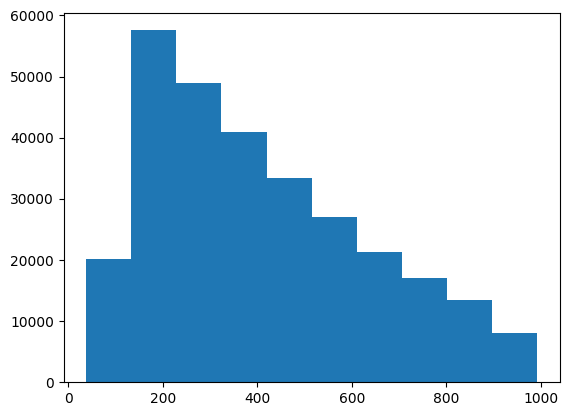

In [10]:
plt.hist(length_array)

In [11]:
X_train_token = [text_to_word_sequence(_) for _ in X_train.astype(str)]
X_val_token = [text_to_word_sequence(_) for _ in X_val.astype(str)]

In [12]:
# Learn embedding representation of words in reviews
word2vec = Word2Vec(sentences=X_train_token, vector_size=50, min_count=10) #Reduced vector size from 100 to 50 and min_count from 5 to 10
# Store words and trained embeddings in wv
wv = word2vec.wv

In [13]:
wv.most_similar("not", topn=10)

[('hardly', 0.6714343428611755),
 ('barely', 0.602747917175293),
 ('though', 0.5431169271469116),
 ('yes', 0.4965512752532959),
 ('never', 0.48427829146385193),
 ('neither', 0.4770137071609497),
 ('nothing', 0.46469846367836),
 ('that', 0.46058890223503113),
 ('noti', 0.4463513493537903),
 ('pretty', 0.439453661441803)]

In [14]:
len(wv.key_to_index.keys())

33128

# Optimized Embedding Function v2 - on disk

In [15]:
import os
import pickle
import numpy as np
from joblib import Parallel, delayed

In [16]:
def process_sentence_batch_to_disk(wv_vectors, wv_vocab, vector_size, sentences_batch, batch_index, output_dir):
    """
    Processes a sentence batch and saves the result to disk using pickle.
    """
    batch_embeddings = []

    for sentence in sentences_batch:
        valid_words = [word for word in sentence if word in wv_vocab]
        if valid_words:
            embeddings = np.array([wv_vectors[word] for word in valid_words])
        else:
            embeddings = np.array([]).reshape(0, vector_size)

        batch_embeddings.append(embeddings)

    # Save batch to disk
    file_path = os.path.join(output_dir, f'batch_{batch_index}.pkl')
    with open(file_path, 'wb') as f:
        pickle.dump(batch_embeddings, f)

    return file_path

In [17]:
def embedding_optimized_to_disk(wv, sentences, batch_size=10, n_jobs=-1, output_dir='embeddings_batches'):
    """
    Optimized embedding function that saves intermediate results to disk to avoid memory overload.
    """
    print(f"Processing {len(sentences)} sentences...")

    os.makedirs(output_dir, exist_ok=True)

    vocab = set(wv.key_to_index.keys())
    vector_size = wv.vector_size
    batches = [sentences[i:i + batch_size] for i in range(0, len(sentences), batch_size)]

    print(f"Created {len(batches)} batches of ~{batch_size} sentences each")
    print(f"Using {n_jobs} parallel processes...")

    # Process and store results to disk in parallel
    result_files = Parallel(n_jobs=n_jobs, verbose=1, backend='loky')(
        delayed(process_sentence_batch_to_disk)(wv, vocab, vector_size, batch, idx, output_dir)
        for idx, batch in enumerate(batches)
    )

    print(f"Embeddings saved to disk at '{output_dir}'. Total: {len(result_files)} files.")
    return result_files

In [18]:
def load_all_embeddings_from_disk(file_paths):
    """
    Load and concatenate embeddings from disk.
    """
    all_embeddings = []
    for path in file_paths:
        with open(path, 'rb') as f:
            all_embeddings.extend(pickle.load(f))
    return all_embeddings

In [32]:
file_paths = embedding_optimized_to_disk(wv, X_train_token, batch_size=50, n_jobs=-1)

Processing 288000 sentences...
Created 5760 batches of ~50 sentences each
Using -1 parallel processes...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 1896 tasks      | elapsed:   32.5s
[Parallel(n_jobs=-1)]: Done 3196 tasks      | elapsed:   46.7s
[Parallel(n_jobs=-1)]: Done 5032 tasks      | elapsed:  1.1min


Embeddings saved to disk at 'embeddings_batches'. Total: 5760 files.


[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  1.2min finished


In [33]:
X_train_embedded = load_all_embeddings_from_disk(file_paths)

In [34]:
len(X_train_embedded)

288000

# Optimized Embedding Function v1

In [20]:
from joblib import Parallel, delayed
import numpy as np
import os

In [21]:
def process_sentence_batch(wv_vectors, wv_vocab, vector_size, sentences_batch):
    """
    Process a batch of sentences efficiently.

    Args:
        wv_vectors: Word2Vec vectors array
        wv_vocab: Set of vocabulary words (for O(1) lookup)
        vector_size: Dimension of word vectors
        sentences_batch: List of sentences to process

    Returns:
        List of numpy arrays (embeddings for each sentence)
    """
    batch_embeddings = []

    for sentence in sentences_batch:
        # Filter valid words using set lookup (O(1))
        valid_words = [word for word in sentence if word in wv_vocab]

        if valid_words:
            # Get embeddings for valid words
            embeddings = np.array([wv_vectors[word] for word in valid_words])
        else:
            # Empty sentence or no valid words
            embeddings = np.array([]).reshape(0, vector_size)

        batch_embeddings.append(embeddings)

    return batch_embeddings

In [22]:
def embedding_optimized(wv, sentences, batch_size=10, n_jobs=-1):
    """
    Optimized embedding function using joblib parallelization.

    Args:
        wv: Word2Vec vectors object
        sentences: List of tokenized sentences
        batch_size: Number of sentences per batch
        n_jobs: Number of parallel jobs (-1 for all cores)

    Returns:
        List of numpy arrays (embeddings for each sentence)
    """
    print(f"Processing {len(sentences)} sentences...")

    # Pre-compute vocabulary set for O(1) lookups
    vocab = set(wv.key_to_index.keys())
    vector_size = wv.vector_size

    # Split sentences into batches
    batches = [sentences[i:i + batch_size]
               for i in range(0, len(sentences), batch_size)]

    print(f"Created {len(batches)} batches of ~{batch_size} sentences each")
    print(f"Using {n_jobs} parallel processes...")

    # Process batches in parallel
    results = Parallel(n_jobs=n_jobs, verbose=1, backend='loky')(
        delayed(process_sentence_batch)(wv, vocab, vector_size, batch)
        for batch in batches
    )

    # Flatten results
    all_embeddings = []
    for batch_result in results:
        all_embeddings.extend(batch_result)

    print(f"Successfully processed {len(all_embeddings)} sentences")
    return all_embeddings

In [23]:
X_train_embedded = embedding_optimized(wv, X_train_token, batch_size=10, n_jobs=-1)

Processing 288000 sentences...
Created 28800 batches of ~10 sentences each
Using -1 parallel processes...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1088 tasks      | elapsed:   32.8s
[Parallel(n_jobs=-1)]: Done 2008 tasks      | elapsed:   49.8s


: 

# Not-Optimized Embedding Function

In [15]:
import numpy as np

In [16]:
def embed_sentence(word2vec, sentence):
    wv = word2vec.wv
    res_matrix = []

    for word in sentence:

        if word in wv:
            res_matrix.append(wv[word])
        else:
            continue

    return np.array(res_matrix)

In [17]:
len(X_train_token[0])

106

In [18]:
#Checks
embedded_sentence = embed_sentence(word2vec, X_train_token[0])

In [19]:
type(embedded_sentence)

numpy.ndarray

In [20]:
assert(type(embedded_sentence) == np.ndarray)
#assert(embedded_sentence.shape == (120, 100))

In [ ]:
def embedding(word2vec, sentences):

    sentences_matrix = []

    for sentence in sentences:
        sentences_matrix.append(embed_sentence(word2vec, sentence))

    return sentences_matrix

: 

In [ ]:
X_train_embedded = embedding(word2vec, X_train_token)

In [20]:
len(X_train_embedded[0])

97

In [21]:
len(X_train_token[0])

100

# Padding

from tensorflow.keras.utils import pad_sequences

In [39]:
type(X_train_embedded[0])

numpy.ndarray

In [41]:
def save_padded_batches(X_embedded, batch_size, maxlen, save_path):
    os.makedirs(save_path, exist_ok=True)
    for i in range(0, len(X_embedded), batch_size):
        batch = X_embedded[i:i+batch_size]
        padded = pad_sequences(batch, maxlen=maxlen, padding='post', dtype='float32')
        np.save(os.path.join(save_path, f"batch_{i//batch_size}.npy"), padded)

In [42]:
save_padded_batches(X_train_embedded, batch_size=100, maxlen=400, save_path="padded_embeddings")

In [40]:
X_train_pad_s = pad_sequences(X_train_embedded, dtype="float32", padding='post', value=0, maxlen=400)

MemoryError: Unable to allocate 21.5 GiB for an array with shape (288000, 400, 50) and data type float32

In [ ]:
X_val_pad_s = pad_sequences(X_val_embedded, dtype="float32", padding='post', value=0, maxlen=50)